# 02: Exploratory Data Analysis and Modeling

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import distance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler


import statsmodels.api as sm
from statsmodels.api import OLS

pd.options.mode.chained_assignment = None
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

%matplotlib inline

## Load In Dataset

In [2]:
# Paths
PATH_YELP_DATA = '../data/yelp_data.csv'
PATH_INSPECTIONS = '../data/nyc_restaurant_inspection_data.csv'
PATH_DEMOGRAPHICS = '../data/demographics_zipcode.csv'

# Global params
nsims = 500

# Import data
df = pd.read_csv('../data/model_data.csv')

# Subset data (inspection year)
# df = df.loc[df['inspection_year'] == 2016, :]

# Response transformations
df['sqrt_score'] = np.sqrt(df['score'])

# Predictor transformations
df['sqrt_score_avg'] = np.sqrt(df['score_avg'])
df['sqrt_score_prev'] = np.sqrt(df['score_prev'])
df['log_review_count'] = np.log(df['review_count'])

## Exploratory Data Analysis

In [4]:
df.head()

,camis,inspection_date,camis.1,dba,zipcode,cuisine_description,inspection_date.1,inspection_year,inspection_month,latitude,longitude,review_count,price,rating,trans_delivery,trans_restaurant_reservation,trans_null,trans_pickup,cat_tradamerican,cat_pizza,cat_french,cat_mediterranean,cat_vegetarian,cat_bars,cat_greek,cat_hotdogs,cat_kosher,cat_caribbean,cat_spanish,cat_sportsbars,cat_japanese,cat_venues,cat_juicebars,cat_bbq,cat_breakfast_brunch,cat_steak,cat_latin,cat_desserts,cat_chinese,cat_mexican,cat_icecream,cat_seafood,cat_bagels,cat_chicken_wings,cat_coffee,cat_sandwiches,cat_bakeries,cat_bubbletea,cat_mideastern,cat_lounges,...,boro_bronx,boro_brooklyn,boro_manhattan,boro_queens,boro_staten island,city_astoria,city_bayside,city_bronx,city_brooklyn,city_bushwick,city_corona,city_elmhurst,city_flushing,city_forest hills,city_fresh meadows,city_howard beach,city_jackson heights,city_jamaica,city_long island city,city_manhattan,city_maspeth,city_new york,city_other,city_ozone park,city_queens,city_queens village,city_rego park,city_richmond hill,city_ridgewood,city_south ozone park,city_south richmond hill,city_staten island,city_sunnyside,city_whitestone,city_woodhaven,city_woodside,score_prev,score_avg,score_std,score_max,score_cnt,time_since_prev,first_inspection,grade,score,log_score,sqrt_score,sqrt_score_avg,sqrt_score_prev,log_review_count
0,30075445,2015-09-04,30075445,MORRIS PARK BAKE SHOP,10462,Bakery,2015-09-04,2015.0,9.0,40.848446,-73.856079,31,2.0,4.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15.107325,15.161442,8.330487,23.787069,3.681254,0.470693,1,A,6.0,2.079442,2.449490,3.893770,3.886814,3.433987
1,30075445,2016-02-18,30075445,MORRIS PARK BAKE SHOP,10462,Bakery,2016-02-18,2016.0,2.0,40.848446,-73.856079,31,2.0,4.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.000000,6.000000,8.330487,6.000000,1.000000,0.457534,0,A,10.0,2.484907,3.162278,2.449490,2.449490,3.433987
2,30075445,2017-05-18,30075445,MORRIS PARK BAKE SHOP,10462,Bakery,2017-05-18,2017.0,5.0,40.848446,-73.856079,31,2.0,4.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.000000,8.000000,2.828427,10.000000,2.000000,1.246575,0,A,7.0,2.197225,2.645751,2.828427,3.162278,3.433987
3,30112340,2015-07-07,30112340,WENDY'S,11225,Hamburgers,2015-07-07,2015.0,7.0,40.662952,-73.961753,30,1.0,2.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8.000000,11.000000,4.242641,14.000000,2.000000,0.517808,0,A,12.0,2.639057,3.464102,3.316625,2.828427,3.401197
4,30112340,2016-03-12,30112340,WENDY'S,11225,Hamburgers,2016-03-12,2016.0,3.0,40.662952,-73.961753,30,1.0,2.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12.000000,11.333333,3.055050,14.000000,3.000000,0.682192,0,NaN,48.0,3.912023,6.928203,3.366502,3.464102,3.401197


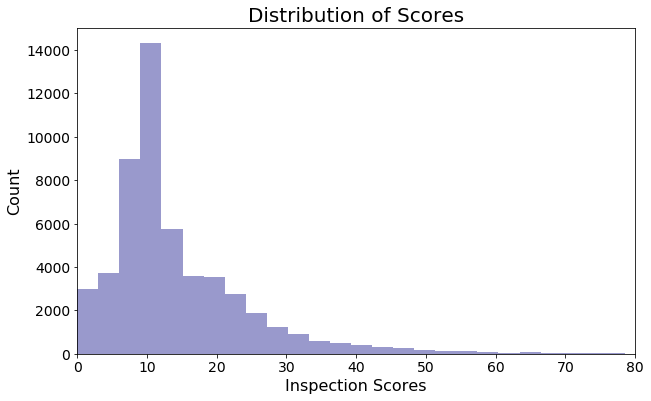

In [3]:
# Distribution of inspection scores
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xlim(0, 80)
ax.set_title("Distribution of Scores", fontsize=20)
ax.set_ylabel("Count", fontsize=16)
sns.distplot(df.score, kde=False, color="navy")
ax.set_xlabel("Inspection Scores", fontsize=16)
plt.tick_params(labelsize=14);


This chart shows us that the distriution of scores is right skewed. This positive skewness needs to be adjusted to a more normal distribution. One possible solution is to apply a log transformation:

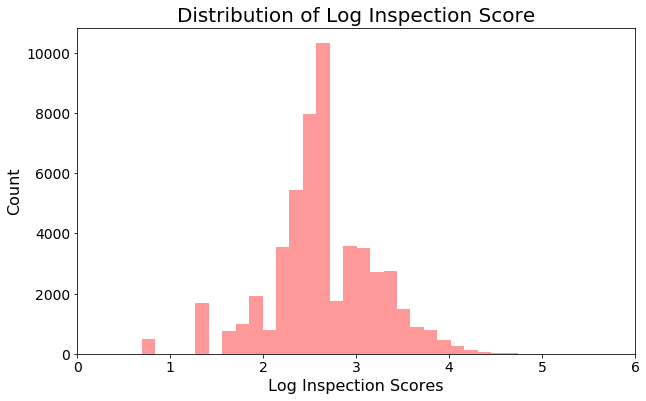

In [5]:
# Distribution of log score
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xlim(0, 6)
ax.set_title("Distribution of Log Inspection Score", fontsize=20)
ax.set_ylabel("Count", fontsize=16)
sns.distplot(np.log(df.score+2), bins=30, kde=False, color="red")
ax.set_xlabel("Log Inspection Scores", fontsize=16)
plt.tick_params(labelsize=14);

We note from the histogram and quantile plots above, that the log transformation is likely the best standard transformation option availble. A significant number of outliers is observed relative to the large concentration of observations around the median of the distribution.

Moving forward, a look at a set of scatter plots below shows associations between the log score and some explanatory variables. In general, we note very weak linear relationships between the response and most of the explanatory variables considered. We do observe a slight decreasing relationship between score and rating, suggesting that restuarants with higher Yelp ratings are less likely to receive a high (poor) inspection score. It is also noted that some of the factors based on historic inspection scores have a relationship with the inspection score. In particular, restaurants with a higher historic average score are more likely to have a high score in future.

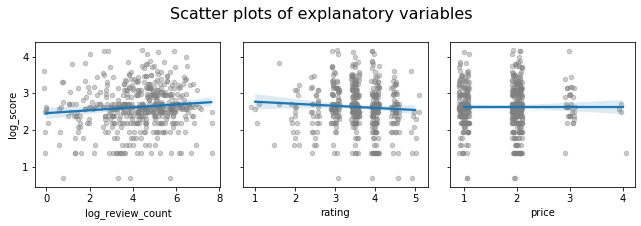

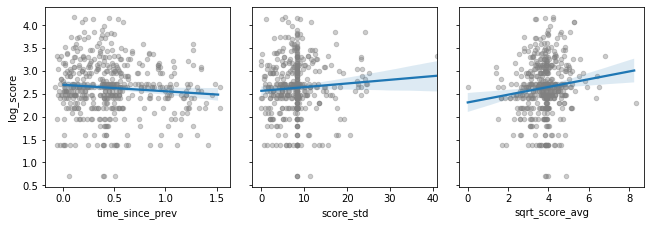

In [6]:
# Yelp ratings and previous inspection scores

df = df.sample(500, random_state=87)
x_vars = ['log_review_count', 'rating', 'price']
g = sns.PairGrid(df, y_vars=["log_score"], x_vars=x_vars[:3], size=3, despine=False)
g.map(sns.regplot, x_jitter=.1, scatter_kws={'s':20,'alpha':0.4, 'color':'grey'});

plt.suptitle("Scatter plots of explanatory variables", fontsize=16);
plt.subplots_adjust(top=0.82);

x_vars = ['time_since_prev', 'score_std', 'sqrt_score_avg']
g = sns.PairGrid(df, y_vars=["log_score"], x_vars=x_vars[:3], size=3, despine=False)
g.map(sns.regplot, x_jitter=.1, scatter_kws={'s':20,'alpha':0.4, 'color':'grey'});

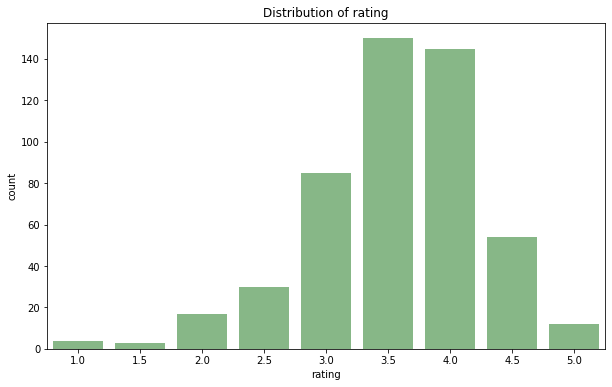

In [7]:
# Distribution of rating
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title("Distribution of rating")
sns.countplot(x="rating", data=df, color='green', alpha=0.5);

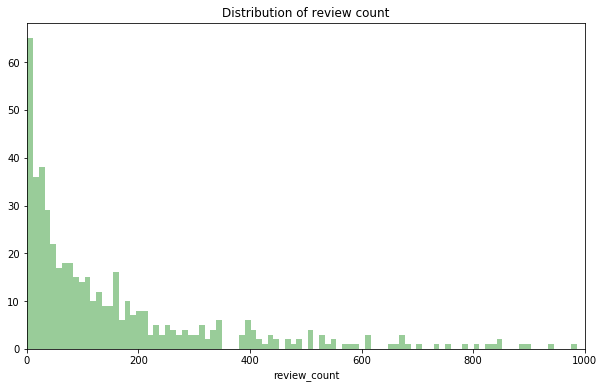

In [8]:
# Distribution of number of reviews
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title("Distribution of review count")
ax.set_xlim(0, 1000)
sns.distplot(df.review_count, kde=False, bins=200, color='green');

In [9]:
# Predictors
model_cols = ['log_review_count', 'rating', 'price', 
              'sqrt_score_avg', 'time_since_prev', 'restaurant_name_chain']

cat_cols = [c for c in df.columns if "cat_" in c]
cat_cols.sort()
for c in cat_cols:
    model_cols.append(c)
        
# Response     
model_cols.append('log_score')

# Create train and test sets
train_df, test_df = train_test_split(df[model_cols], test_size=0.5, random_state=87)

# Model predictors
X_train = train_df.iloc[:,:-1].values
X_test = test_df.iloc[:,:-1].values

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Response
y_train = train_df.iloc[:,-1].values
y_test = test_df.iloc[:,-1].values

# Fit model
mod = OLS(y_train, X_train)
res = mod.fit()

# Print summary statistics
names = ['const'] + list(train_df.columns[:-1])
appdx_3_mod3summary = res.summary(xname=names)
appdx_3_mod3summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     1.361
Date:                Mon, 08 Jun 2020   Prob (F-statistic):             0.0687
Time:                        20:12:04   Log-Likelihood:                -174.02
No. Observations:                 250   AIC:                             456.0
Df Residuals:                     196   BIC:                             646.2
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.6761      0.382      7.000      0.000       1.922       3.430
log_review_count         -0.0066      0.029     -0.227      0.821      -0.064       0.051
rating                   -0.0752      0.065     -1.164      0.246      -0.203       0.052
price                    -0.0380      0.079     -0.484      0.629      -0.193       0.117
sqrt_score_avg            0.0640      0.050      1.273      0.205      -0.035       0.163
time_since_prev          -0.0468      0.111     -0.423      0.673      -0.265       0.172
restaurant_name_chain    -0.5796      0.234     -2.476      0.014      -1.041      -0.118
cat_asianfusion           0.4276      0.346      1.234      0.219      -0.256       1.111
cat_bagels               -0.0032      0.278     -0.011      0.991      -0.552       0.545
cat_bakeries              0.0141      0.187      0.075      0.940      -0.355       0.383
cat_bars                 -0.0034      0.182     -0.019      0.985      -0.362       0.356
cat_bbq                  -0.3825      0.398     -0.960      0.338      -1.168       0.403
cat_breakfast_brunch      0.1912      0.165      1.162      0.247      -0.133       0.516
cat_bubbletea         -7.267e-16   4.01e-16     -1.812      0.071   -1.52e-15    6.41e-17
cat_burgers              -0.0104      0.182     -0.057      0.955      -0.370       0.349
cat_cafes                -0.0775      0.210     -0.368      0.713      -0.493       0.338
cat_caribbean             0.4349      0.314      1.386      0.167      -0.184       1.054
cat_chicken_wings         0.2925      0.358      0.816      0.415      -0.414       0.999
cat_chinese               0.0738      0.167      0.442      0.659      -0.255       0.403
cat_cocktailbars         -0.0349      0.290     -0.121      0.904      -0.606       0.536
cat_coffee               -0.0075      0.165     -0.045      0.964      -0.332       0.318
cat_delis                 0.5153      0.580      0.888      0.375      -0.629       1.660
cat_desserts             -0.4199      0.178     -2.364      0.019      -0.770      -0.070
cat_diners                0.1599      0.278      0.576      0.565      -0.388       0.708
cat_french                0.2321      0.347      0.668      0.505      -0.453       0.917
cat_greek                 0.0925      0.302      0.306      0.760      -0.503       0.688
cat_hotdogs               0.3760      0.287      1.311      0.191      -0.189       0.941
cat_icecream             -0.6618      0.346     -1.915      0.057      -1.343       0.020
cat_indpak                0.4300      0.226      1.902      0.059      -0.016       0.876
cat_italian               0.2090      0.143      1.462      0.145      -0.073       0.491
cat_japanese             -0.3847      0.218     -1.767      0.079      -0.814       0.045
cat_juicebars          

In [10]:
df.head()

,camis,inspection_date,camis.1,dba,zipcode,cuisine_description,inspection_date.1,inspection_year,inspection_month,latitude,longitude,review_count,price,rating,trans_delivery,trans_restaurant_reservation,trans_null,trans_pickup,cat_tradamerican,cat_pizza,cat_french,cat_mediterranean,cat_vegetarian,cat_bars,cat_greek,cat_hotdogs,cat_kosher,cat_caribbean,cat_spanish,cat_sportsbars,cat_japanese,cat_venues,cat_juicebars,cat_bbq,cat_breakfast_brunch,cat_steak,cat_latin,cat_desserts,cat_chinese,cat_mexican,cat_icecream,cat_seafood,cat_bagels,cat_chicken_wings,cat_coffee,cat_sandwiches,cat_bakeries,cat_bubbletea,cat_mideastern,cat_lounges,...,boro_bronx,boro_brooklyn,boro_manhattan,boro_queens,boro_staten island,city_astoria,city_bayside,city_bronx,city_brooklyn,city_bushwick,city_corona,city_elmhurst,city_flushing,city_forest hills,city_fresh meadows,city_howard beach,city_jackson heights,city_jamaica,city_long island city,city_manhattan,city_maspeth,city_new york,city_other,city_ozone park,city_queens,city_queens village,city_rego park,city_richmond hill,city_ridgewood,city_south ozone park,city_south richmond hill,city_staten island,city_sunnyside,city_whitestone,city_woodhaven,city_woodside,score_prev,score_avg,score_std,score_max,score_cnt,time_since_prev,first_inspection,grade,score,log_score,sqrt_score,sqrt_score_avg,sqrt_score_prev,log_review_count
17679,41355657,2015-09-13,41355657,PRIMA PIZZA,11428,Pizza,2015-09-13,2015.0,9.0,40.728153,-73.735664,41,1.0,3.0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,11.0,20.714286,11.814035,39.0,7.0,0.293151,0,NaN,22.0,3.178054,4.690416,4.551295,3.316625,3.713572
15160,41262328,2015-06-24,41262328,MCDONALD'S,10003,Hamburgers,2015-06-24,2015.0,6.0,40.736871,-73.990676,71,1.0,2.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,10.500000,0.707107,11.0,2.0,0.438356,0,A,10.0,2.484907,3.162278,3.240370,3.162278,4.262680
38353,50007230,2015-04-15,50007230,TINTO,11216,Coffee_Tea,2015-04-15,2015.0,4.0,40.672842,-73.950209,122,1.0,4.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16.0,11.500000,6.363961,16.0,2.0,0.095890,0,NaN,22.0,3.178054,4.690416,3.391165,4.000000,4.804021
27082,41618219,2017-05-16,41618219,MORSO,10022,Italian,2017-05-16,2017.0,5.0,40.758701,-73.960938,97,3.0,3.5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30.0,15.000000,8.426150,30.0,5.0,0.430137,0,A,12.0,2.639057,3.464102,3.872983,5.477226,4.574711
36144,50003283,2015-11-10,50003283,8 DRAGON & PHOENIX CHINESE RESTAURANT,11105,Chinese,2015-11-10,2015.0,11.0,40.775852,-73.911285,17,1.0,4.5,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.0,19.666667,11.129540,37.0,6.0,0.082192,0,NaN,8.0,2.302585,2.828427,4.434712,3.316625,2.833213


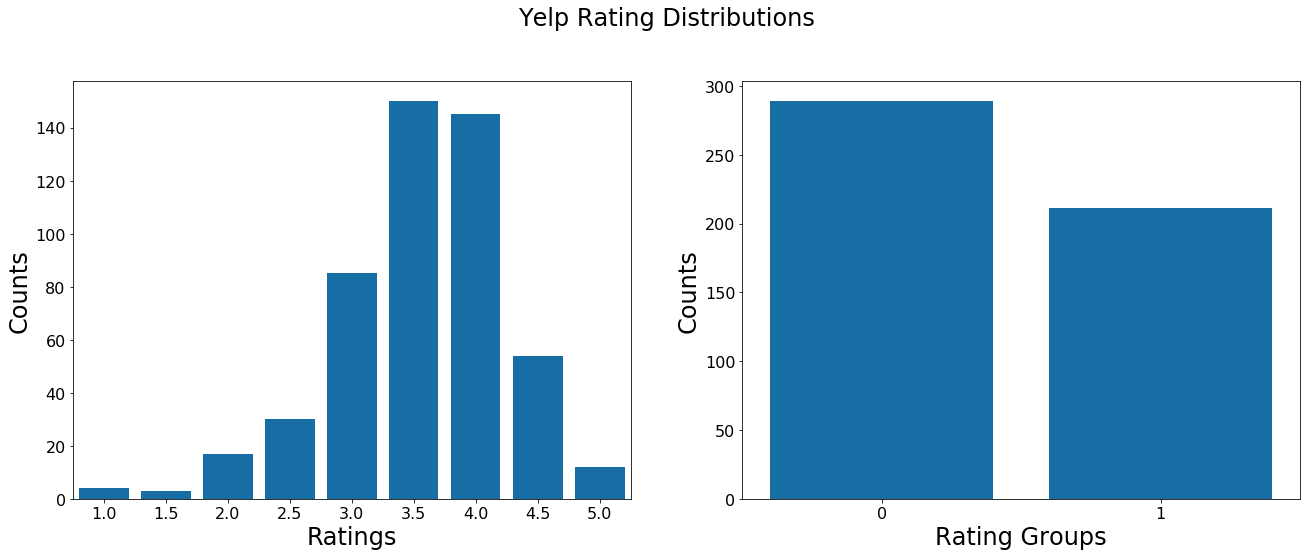

In [11]:
# Data prep

def rating_group(row):
    if row < 4:
        label = 0
    else:
        label = 1
    return label

# Creating 'rating group' response
df['rating_grp'] = df['rating'].apply(rating_group)

# Plot number of observations in each group
fig, ax = plt.subplots(1, 2, figsize=(22, 8))

rt = sns.countplot(df['rating'], color='#0073bb', ax=ax[0])
rt.axes.set_xlabel("Ratings",fontsize=24)
rt.axes.set_ylabel("Counts", fontsize=24);
rtgrp = sns.countplot(df['rating_grp'], color='#0073bb', ax=ax[1])
rtgrp.axes.set_xlabel("Rating Groups", fontsize=24)
rtgrp.axes.set_ylabel("Counts", fontsize=24);

plt.suptitle("Yelp Rating Distributions", fontsize=24);
plt.subplots_adjust(top=0.85);
plt.tick_params(labelsize=16);
rt.tick_params(labelsize=16);


## Modeling

### Baseline

In [12]:
df['rating_grp'].value_counts(normalize=True)

0    0.578
1    0.422
Name: rating_grp, dtype: float64

Above we see that we have a baseline score of 57.6%.

### Logistic Regression

In [13]:
# Data prep
col = 'grade'
df2 = pd.get_dummies(df[col], prefix=col)
df = df.join(df2, rsuffix='2')
df.drop(col, axis=1, inplace=True)

In [14]:
# Selected predictors + response
model_cols = ['log_review_count', 'price', 'log_score', 'sqrt_score_avg']
X = df[model_cols]
y = df['rating_grp']

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


# Fit model
clf = LogisticRegressionCV(Cs=10, cv=10, n_jobs=4, penalty='l1', solver='liblinear', verbose=0)
clf.fit(X_train, y_train)

# Train accuracy
acc = clf.score(X_train, y_train)

In [15]:
clf.score(X_train, y_train)

0.656

In [16]:
clf.score(X_test, y_test)

0.616

In [17]:
clf.coef_

array([[ 0.213161  ,  0.24105974, -0.48350155, -0.11184836]])

From the logistic regression test score, it is clear that our logistic regression model is only marginally better at at identifying restaurants with a rating under four stars (class 0). The model correctly classifies 61.6% of observations included in the test dataset, only 3.8% more than the baseline.

### Confusion Matrix

In [18]:
# get predictions for test set 
predictions = clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()


# Creating confusion matrix 
cm = confusion_matrix(predictions,y_test)
cm# Visualizing our confusion matrix  
pd.DataFrame(cm, index=['Predicted < 4 Stars', 'Predicted >= 4 Stars'],
                 columns=['Actual < 4 Stars', 'Actual >= 4 Stars'])

,Actual < 4 Stars,Actual >= 4 Stars
Predicted < 4 Stars,62,38
Predicted >= 4 Stars,10,15


In [19]:
acc = round((6669 + 1242)/ (6669 + 1242 + 4312 + 893), 2)
miss = round(1 - acc, 2)
sens = round(6669 / (6669 + 893),2)
spec = round(893 / (1242 + 4312),2)
prec = round(6669 / (6669 + 4312),2)
print(f'Accuracy: {acc}')
print(f'Misclassification Rate: {miss}')
print(f'Sensitivity: {sens}')
print(f'Specificity: {spec}')
print(f'Precision: {prec}')

Accuracy: 0.6
Misclassification Rate: 0.4
Sensitivity: 0.88
Specificity: 0.16
Precision: 0.61


Interpretation: Our ability to trust our prediction of a business having a rating of at least four stars is 60% (Accuracy). We have a True Negative Rate (specificity) of 16% and a True Positive Rate (sensitivity) of 88%.

## Conclusions and Next Steps

The evolution of this project has been based around the continuous exploration and understanding of Yelp's data and API. The initial goal of conducting natural language processing based on Yelp reviews was shelved due to two important reasons. First, the Yelp Fusion API endpoint for reviews is limited to only three reviews per business sorted according to Yelp's default sort order. Furthermore, the Yelp API does not return the full text and only returns the first 160 characters per review. This makes it extremely difficult to do any sort of NLP. Secondly, Yelp reviews are notorious for containing fake reviews submitted in order to artificially boost a business' rating. While several open-source and commercial programs are available to assist in detecting these reviews, it is unclear how effective these programs are.

One reccomended next step in further improving this project is to analyze additional health inspections on more years. While this may require additional get requests to the Yelp Fusion API, it will result in a more accurate and longer-term picture of the restaurant's health inspection scores. Another recommendation is to add additional features in order to see if it improves the model. This could include incorporating public and proprietary datasets that relate to the food industry. One example could be Michelin star ratings, often considered a high standard of dining excellence. 

## References

- Yelp Fusion API Endpoint Documentation, https://www.yelp.com/developers/documentation/v3
- NYC OpenData, “DOHMH DOHMH New York City Restaurant Inspection Results https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j
- Python Timer Functions: Three Ways to Monitor Your Code https://realpython.com/python-timer/#creating-a-python-timer-class
- How to Use the Yelp’s Fusion API https://medium.com/@morgannegagne/how-to-use-the-yelp-fusion-api-70e62f96b0ab
- Levenshtein Distance and Text Similarity in Python https://stackabuse.com/levenshtein-distance-and-text-similarity-in-python/